# Projecting requantified expression of arbitrary sequences to single cells

## 1. Login and Connecting to the Malva Index

From the previous notebook `00_setup_malva_client.ipynb`, paste here the `API_TOKEN` you got from us, or if you login with ORCID, generate a new one from your user profile in [https://malva.mdc-berlin.de](https://malva.mdc-berlin.de)

In [ ]:
API_TOKEN = "" # put your API token here

Then, you are ready to use the `malva_client`

In [ ]:
import dnaio
from malva_client import MalvaClient
from malva_client.tools import mask_sequence

client = MalvaClient("https://malva.mdc-berlin.de", API_TOKEN)

INFO:malva_client.client:Connected to Malva API: healthy
INFO:malva_client.client:Authenticated successfully: free account


You also need to install `scanpy` for downstream analysis

In [ ]:
!pip install scanpy

## 2. Searching all cells

Malva enables requantification of any sequence across all cells in the index, with projection to gene expression data

The workflow has these steps:
1. **Requantification**: of any arbitrary sequence, e.g., endogenous retroviruses, pathogens, synthetic constructs...
2. **Sample retrieval**: Download complete expression profiles for any samples where the sequence is found
- **Feature projection**: Map Malva quantifications onto single-cell data
- **Differential analysis**: Compare positive vs. negative cell populations
- **Pathway enrichment**: Identify biological processes associated with your sequence

This workflow identifies cellular mechanisms correlated with expression

### 3.1 Quantifying  a feature across the Malva Index

Again, we create a query for the RNA sequence in the file

In [3]:
with dnaio.open("rna.fna") as f_in:
    for s in f_in:
        seq = s.sequence
        break

results = client.search_cells(seq)

INFO:malva_client.client:Search completed immediately with job ID: ed679c0b-6ba6-4a9d-9eb1-da36b166495e


DEBUG: Found nested results structure
DEBUG: Processing key 'seq_1' with type <class 'dict'>
DEBUG: Found 508144 cells, 508144 expressions, 508144 samples
✓ Processed 508144 cells from 6373 samples


In [4]:
df_cells = results.enrich_with_metadata()

✓ Enriched with metadata for 6373 samples


In [5]:
# we just select one of the samples arbitrarily
selected_sample = df_cells['uuid'].unique()[0]

In [6]:
# we can look at the metadata
df_cells[df_cells['uuid'] == selected_sample][['project.contributors.laboratory',
                                               'project.project_core.project_short_name',
                                               'project.project_core.project_title',
                                               'protocol_harmonized',
                                               'specimen_from_organism.organ',
                                               'development_stage']].drop_duplicates().T

,0
project.contributors.laboratory,"Department of Cardiology, School of Medicine, ..."
project.project_core.project_short_name,CD34LineageMyocardialDu
project.project_core.project_title,Single cell and lineage tracing studies reveal...
protocol_harmonized,sc_10x_v3
specimen_from_organism.organ,heart
development_stage,human adult stage


Now we take a look at the summary and pick one of the top samples that might be interesting, in this case, we can take one of the positive samples.

In [7]:
sample = client.download_sample(selected_sample)

# we remove the raw data so we show the DE in normalised counts
del sample.raw

INFO:malva_client.client:Downloading pseudoquant_annotated_llm_finer_refined.h5ad (133,416,000 bytes)


Downloading: 100.0% (133,416,000/133,416,000 bytes)


INFO:malva_client.client:Loaded sample 01269e2c-67ae-40ef-82a7-b2a3e46e74e0 into memory


In [8]:
sample

AnnData object with n_obs × n_vars = 10687 × 4670
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_umi_counts', 'is_cell', 'n_counts', 'leiden', 'cell_type', 'annotation_confidence', 'score_technical_Housekeeping', 'score_technical_Ribosomal', 'technical_Housekeeping_mean', 'technical_Housekeeping_percent', 'technical_Ribosomal_mean', 'technical_Ribosomal_percent', 'cell_type_llm', 'cell_type_llm_confidence'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'non_technical', 'n_cells'
    uns: 'cell_type_colors', 'cluster_annotations', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
import scanpy as sc
import matplotlib.pyplot as plt

In [10]:
# we select the specific sample
df_cells = df_cells[df_cells['uuid'] == selected_sample]
df_cells.index = df_cells['cell_id'].astype(str)

# we assign to the sample cells
import numpy as np
sample.obs['seq_malva'] = np.log1p(df_cells['expression'])

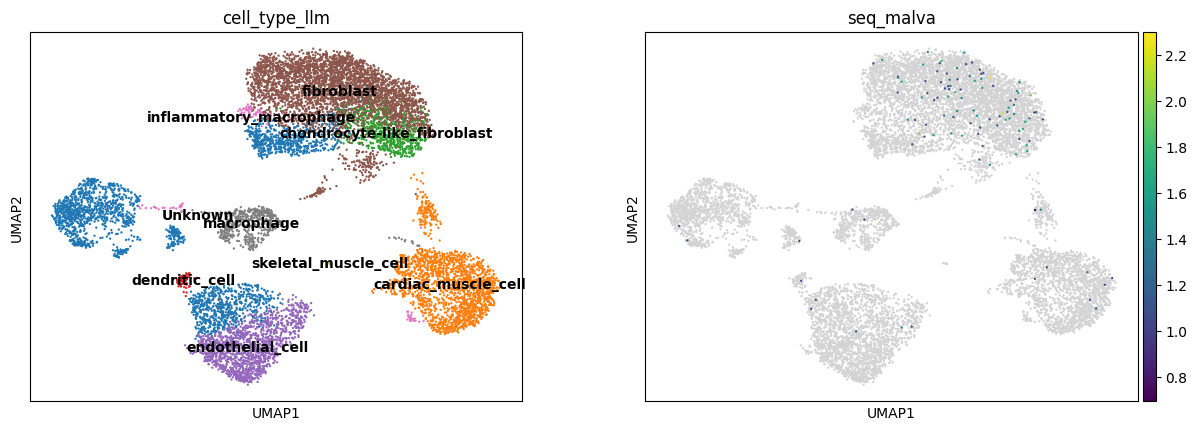

In [11]:
sc.pl.umap(sample, color=['cell_type_llm', 'seq_malva'], legend_loc='on data')

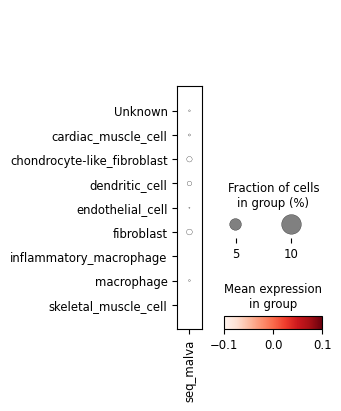

In [12]:
sc.pl.dotplot(sample, ['seq_malva'], groupby='cell_type_llm')

Applied neighbor smoothing with alpha=0.5, iterations=10
Smoothed values stored in adata.obs['seq_malva_smoothed']


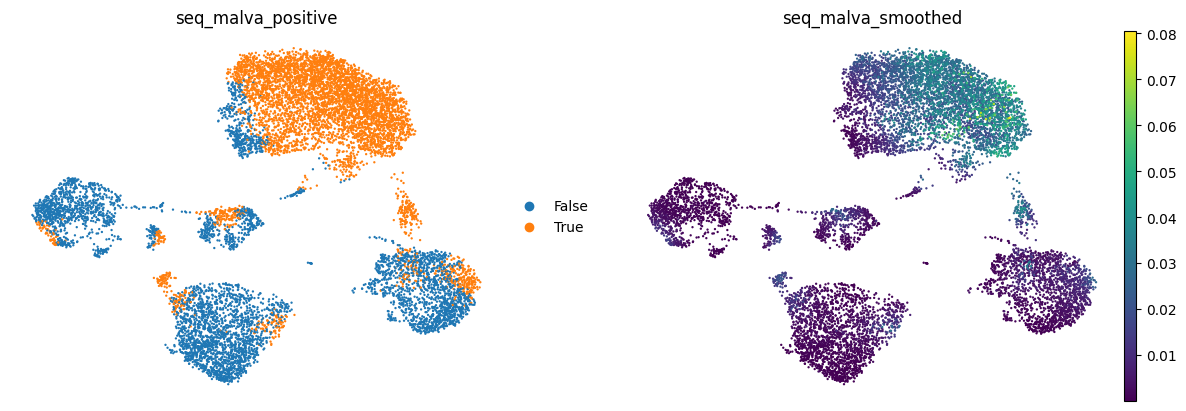

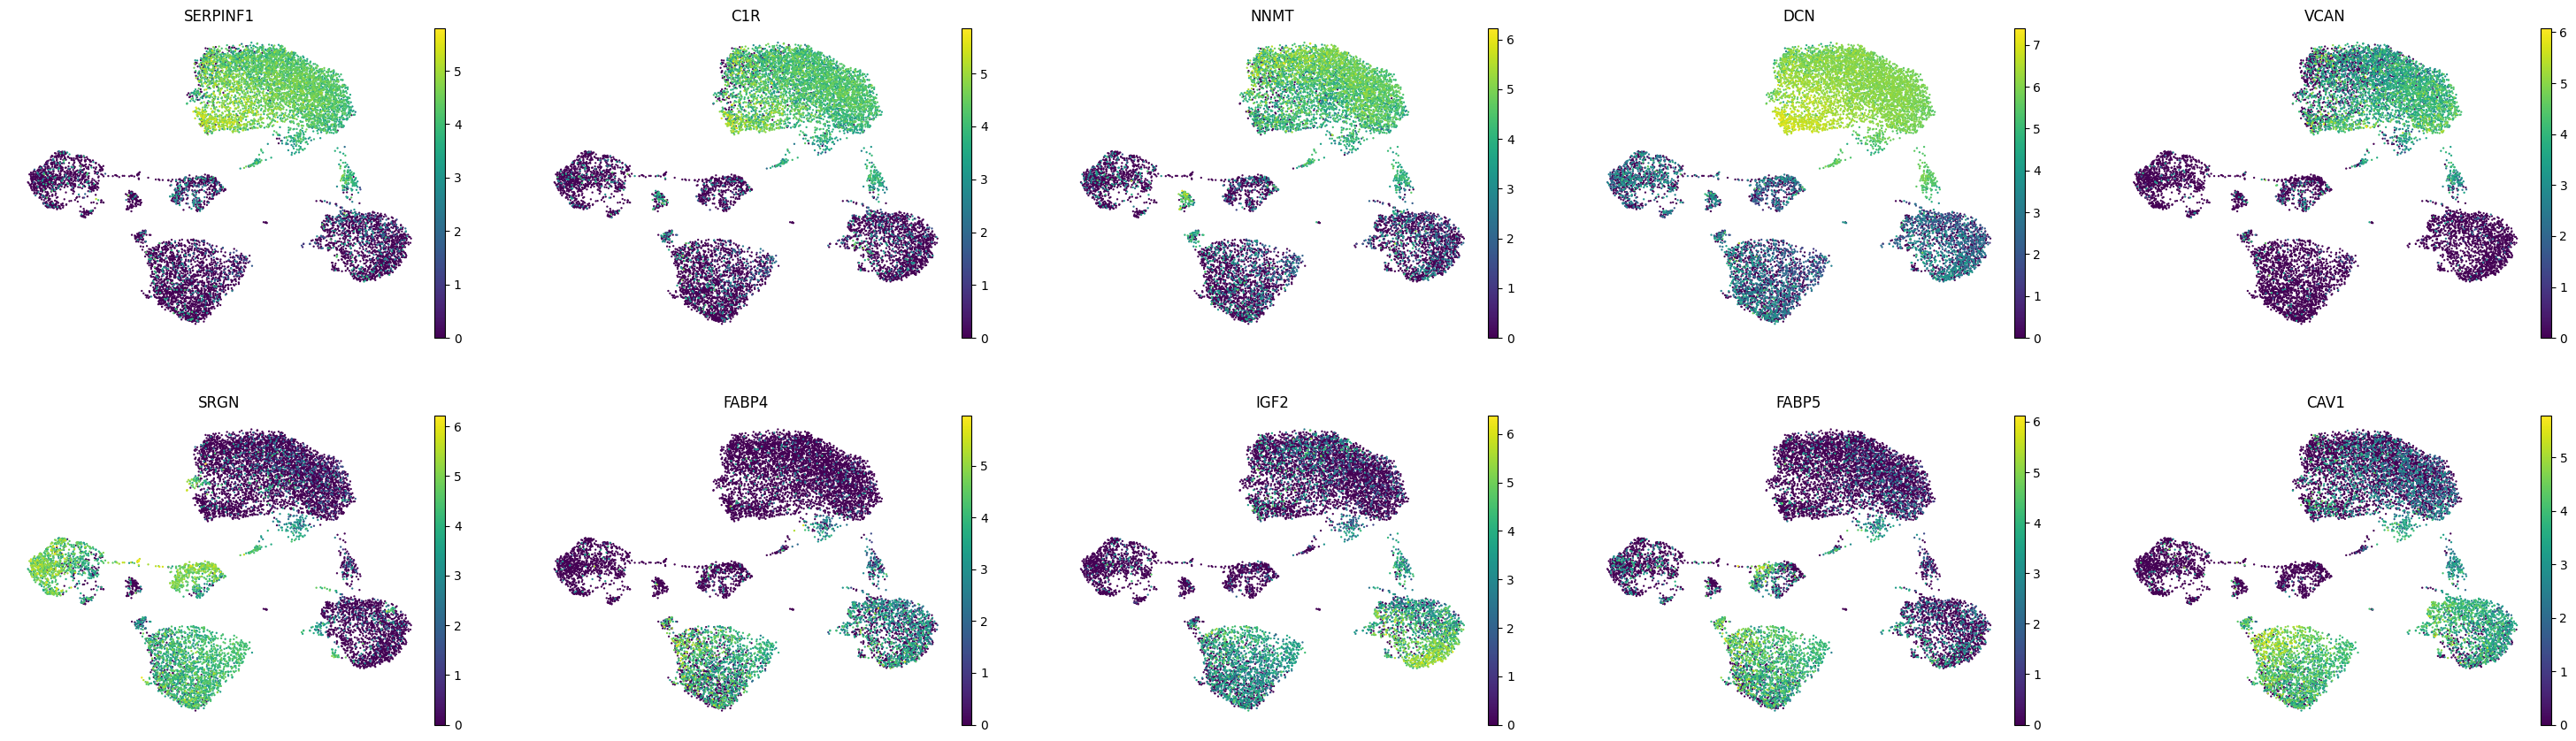

In [13]:
from malva_client.tools import score_correlated_features

thr, pos, neg = score_correlated_features(
    sample,
    feature_key="seq_malva",
    method="gmm",
    gmm_components=2,
    n_markers=5,
    significance=0.05,
    show=True,
    smooth_alpha=0.5,
    smooth_iterations=10,
    smooth_neighbors=True
)

thr, pos, neg = score_correlated_features(
    sample,
    feature_key="seq_malva",
    method="gmm",
    gmm_components=2,
    n_markers=50,
    significance=0.01,
    show=False,
    smooth_alpha=0.5,
    smooth_iterations=10,
    smooth_neighbors=True
)

    native                                                                    name      p_value  intersection_size
GO:0062023                                collagen-containing extracellular matrix 5.165359e-32                 27
GO:0031012                                                    extracellular matrix 1.190163e-29                 28
GO:0030312                                        external encapsulating structure 1.251572e-29                 28
GO:0005201                             extracellular matrix structural constituent 1.300763e-28                 21
GO:0005576                                                    extracellular region 1.776594e-20                 42
GO:0005615                                                     extracellular space 6.119209e-16                 35
GO:0005788                                             endoplasmic reticulum lumen 1.335984e-15                 16
GO:0005581                                                         collagen trim

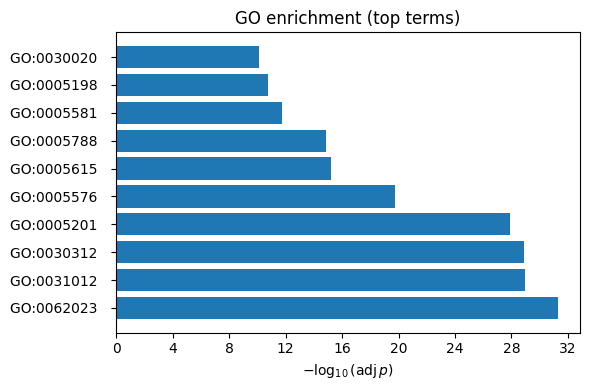

In [14]:
from malva_client.tools import run_go_enrichment

res = run_go_enrichment(
    pos,
    organism = "hsapiens",
    significance = 0.05,
    top_n = 10,
    plot = True
)